In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap



# Task One

## 1(a) Loading data & constructing feature vectors

In [2]:
df = pd.read_csv("./data/train.csv")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Text'])

print(f"number of articles: {X.shape[0]}")
print(f"number of extracted features: {X.shape[1]}\n")

example_df = pd.DataFrame(
    X[:5].toarray(),
    columns=vectorizer.get_feature_names_out()
)
print("5 example articles with their extracted features:")
print(example_df)

number of articles: 428
number of extracted features: 13518

5 example articles with their extracted features:
   00  000  000th  001st  0051  007  0100  0130  028  05  ...  zola  zombie  \
0   0    1      0      0     0    0     0     0    0   0  ...     0       0   
1   0    0      0      0     0    0     0     0    0   0  ...     0       0   
2   0    0      0      0     0    0     0     0    0   0  ...     0       0   
3   0    0      0      0     0    0     0     0    0   0  ...     0       0   
4   0    0      0      0     0    0     0     0    0   0  ...     0       0   

   zombies  zone  zonealarm  zones  zoom  zooms  zooropa  zorro  
0        0     0          0      0     0      0        0      0  
1        0     0          0      0     0      0        0      0  
2        0     0          0      0     0      0        0      0  
3        0     0          0      0     0      0        0      0  
4        0     0          0      0     0      0        1      0  

[5 rows x 13518 c

## 1(b) Term Frequency Analysis

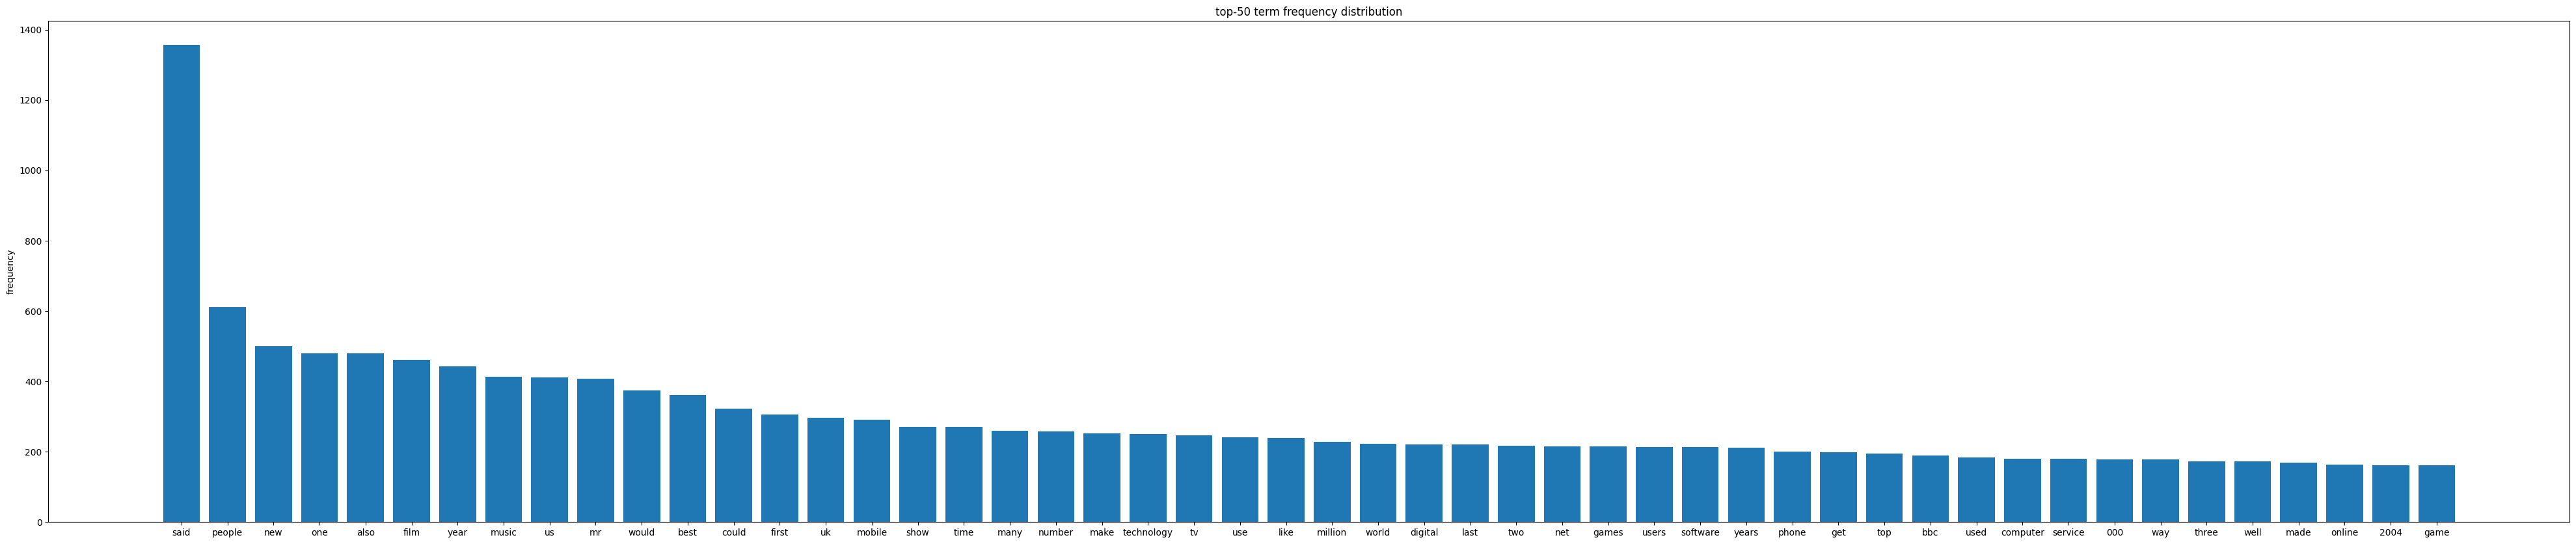

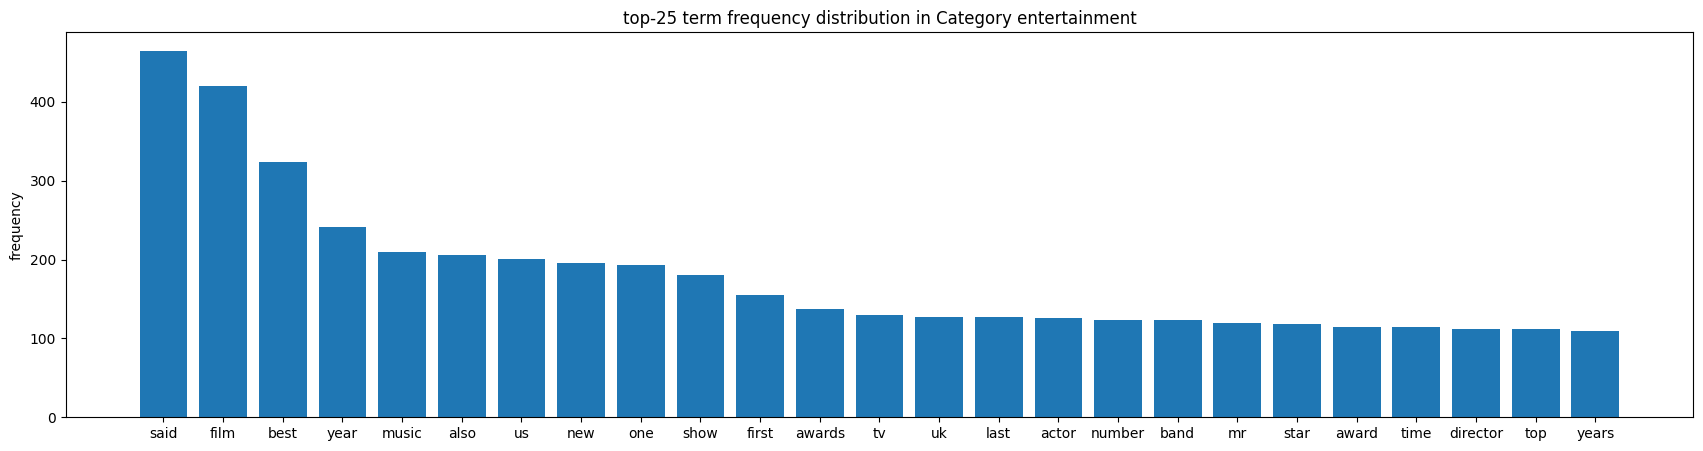

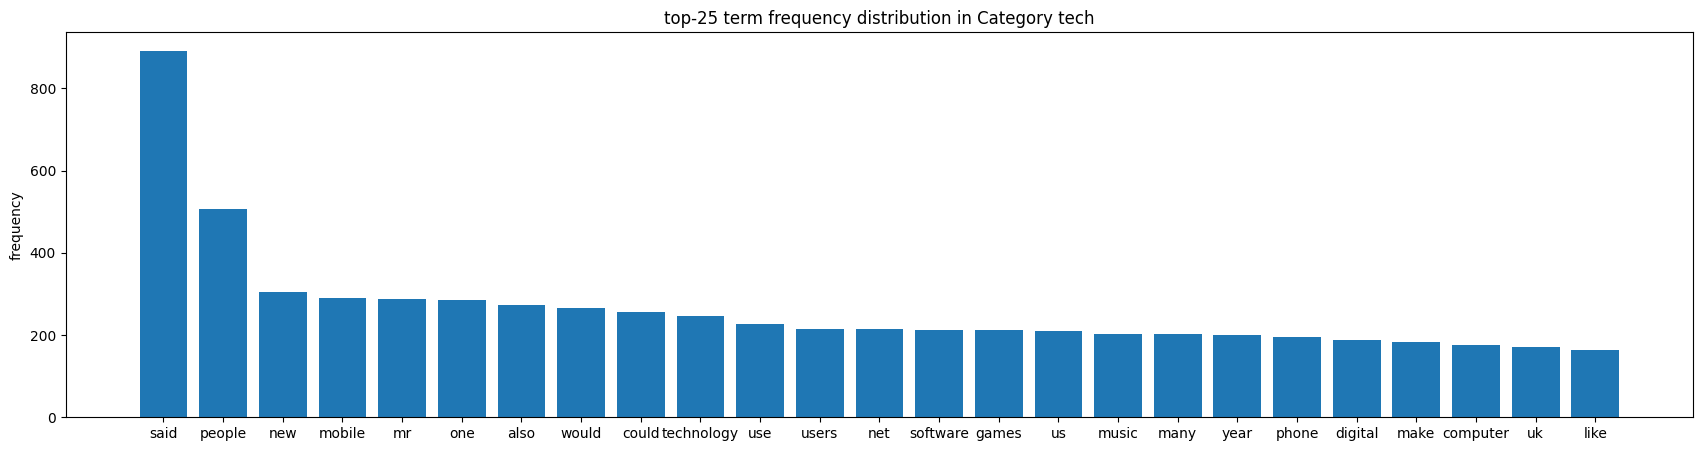

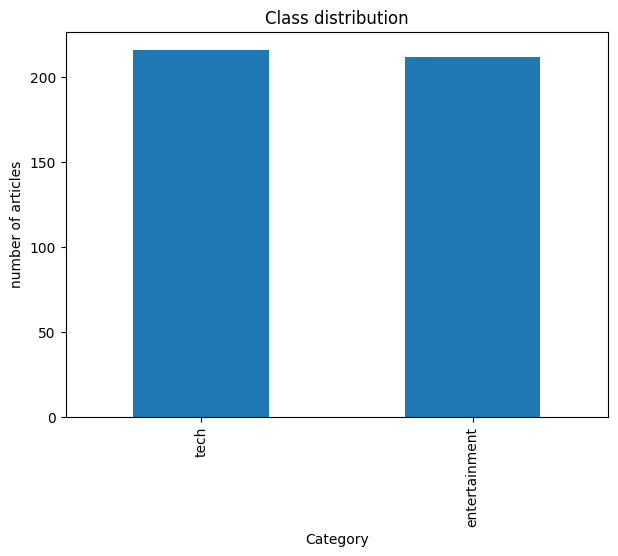

In [3]:
plt.figure(figsize=(50,10))
total_word = (' '.join(df['Text'])).split()
frequency = Counter(total_word).most_common(50)
plt.bar([w[0] for w in frequency],[w[1] for w in frequency])
plt.title("top-50 term frequency distribution")
plt.ylabel('frequency')
plt.show()

label = ['entertainment','tech']
for l in label:
    plt.figure(figsize=(21,5))
    total_text = (' '.join(df[df['Category'] == l]['Text'])).split()
    frequency = Counter(total_text).most_common(25)
    plt.bar([w[0] for w in frequency],[w[1] for w in frequency])
    plt.title(f"top-25 term frequency distribution in Category {l}")
    plt.ylabel('frequency')
    plt.show()

plt.figure(figsize=(7,5))
df['Category'].value_counts().plot(kind = 'bar')
plt.title('Class distribution')
plt.ylabel('number of articles')
plt.show()

# Task Two

## 2(a) Naive Bayes

In [4]:
y = df['Category']
words = vectorizer.get_feature_names_out()

nb_all_data = MultinomialNB()
nb_all_data.fit(X,y)

logprob = nb_all_data.feature_log_prob_
prob = np.exp(logprob)
classes = enumerate(nb_all_data.classes_)

#(i)
print('Top-20 words that most likely to occurr')
for index, cla in classes:
    indice = np.argsort(-prob[index])[:20]
    word = words[indice]
    print(f"Category {cla}: {list(word)}")
print('\n')

#(ii)
print('Top-20 words that maximize the quantity')
classes = enumerate(nb_all_data.classes_)
for index, cla in classes:
    p_Yequaly = logprob[index]
    p_Ynotequaly = logprob[1-index]
    logratio = p_Yequaly - p_Ynotequaly

    ratio = np.exp(logratio)
    indice = np.argsort(-ratio)[:20]
    word = words[indice]
    print(f"Category {cla}: {list(word)}")

Top-20 words that most likely to occurr
Category entertainment: ['said', 'film', 'best', 'year', 'music', 'also', 'us', 'new', 'one', 'show', 'first', 'awards', 'tv', 'uk', 'last', 'actor', 'number', 'band', 'mr', 'star']
Category tech: ['said', 'people', 'new', 'mobile', 'mr', 'one', 'also', 'would', 'could', 'technology', 'use', 'users', 'net', 'software', 'games', 'us', 'music', 'many', 'year', 'phone']


Top-20 words that maximize the quantity
Category entertainment: ['actress', 'singer', 'oscar', 'stars', 'aviator', 'band', 'nominated', 'rock', 'festival', 'album', 'nominations', 'charles', 'chart', 'foxx', 'oscars', 'starring', 'singles', 'jamie', 'swank', 'comedy']
Category tech: ['users', 'software', 'microsoft', 'mobile', 'broadband', 'virus', 'firms', 'pc', 'spam', 'phones', 'gadget', 'net', 'consumer', 'mobiles', 'gadgets', 'windows', 'machines', 'technologies', 'systems', 'device']


## 2(b) kNN

In [5]:
#kNN code goes here

# y = df['Category']
# knn_classifier = KNeighborsClassifier(n_neighbors=3)
# knn_classifier.fit(X, y)

# Using k = 5 and Manhattan distance 
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', p=1)

# Fit 
knn.fit(X, y)


KNeighborsClassifier(metric='manhattan', p=1)

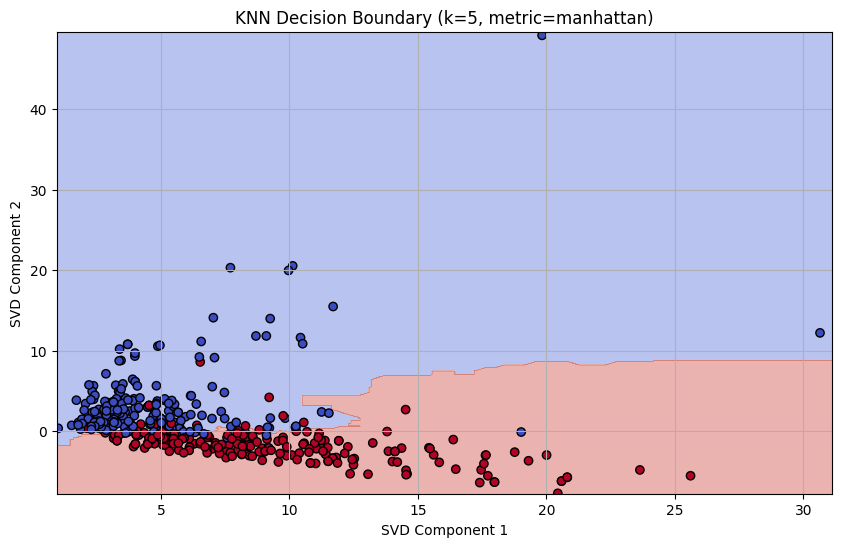

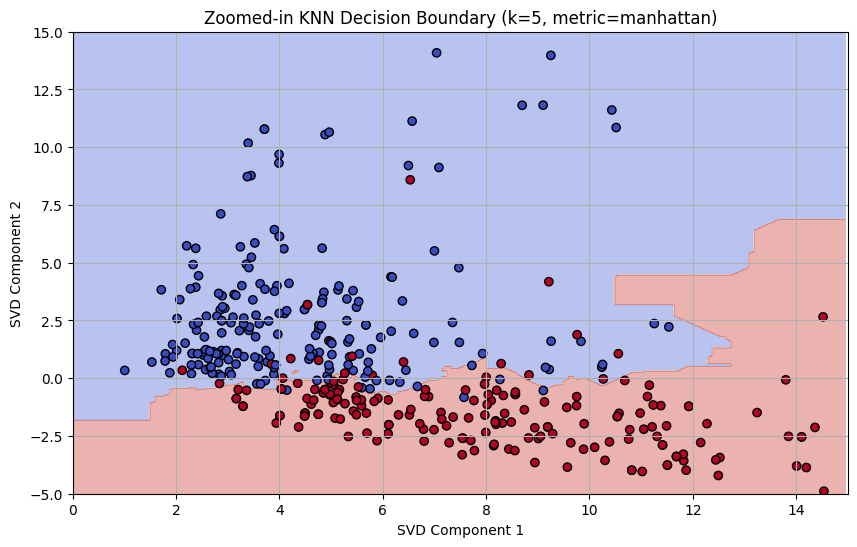

In [6]:
#knn surface plot

# Reduce dimensionality to 2D for visualization
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X)

# Define 2D grid over the projected data space
h = 0.05  # step size for grid
x_min, x_max = X_2d[:, 0].min() - h, X_2d[:, 0].max() + h*10
y_min, y_max = X_2d[:, 1].min() - h, X_2d[:, 1].max() + h*10

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#Encode string labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#Train kNN classifier using 2D features
knn.fit(X_2d, y_encoded)

# Predict labels over the grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid_points)
Z = Z.reshape(xx.shape)
# Plot decision surface and original data points
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.4)  # decision boundary
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, edgecolors='k')  # data points
plt.title("KNN Decision Boundary (k=5, metric=manhattan)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.grid(True)
plt.show()

# Zoomed-in version: focus on region where most points cluster
x_min, x_max = 0, 15
y_min, y_max = -5, 15
h = 0.05

# Generate the grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict class for each grid point
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid_points)
Z = Z.reshape(xx.shape)

# Plot zoomed-in decision surface
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.4)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Zoomed-in KNN Decision Boundary (k=5, metric=manhattan)")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.grid(True)
plt.xlim(0, 15)
plt.ylim(-5, 15)

plt.show()
plt.show()

To visualize the decision boundary of my kNN classifier, we used SVD to reduce the high-dimensional text feature vectors to two components. The surface plot above shows the predicted class regions using k=5 and Manhattan distance.

The first surface plot shows the overall decision boundary. From this full view, we noticed that most data points are clustered within a small region, roughly between SVD component 1 = [0, 15] and component 2 = [0, 15]. To better analyze the boundary behavior in the most informative area, we generated a zoomed-in version focusing on that region.

In the zoomed-in plot, the decision boundary appears relatively smooth, with clear separation between the two classes. A smaller k (e.g., k=1) would create very jagged, overfitted boundaries that conform too closely to the training data. In contrast, a larger k would produce overly smoothed boundaries that might ignore local structure. 

We also observe that the Manhattan distance metric tends to produce more “boxy” decision boundaries. If we were to use Euclidean distance, the boundary would likely be smoother. 

## 2(c) SVM

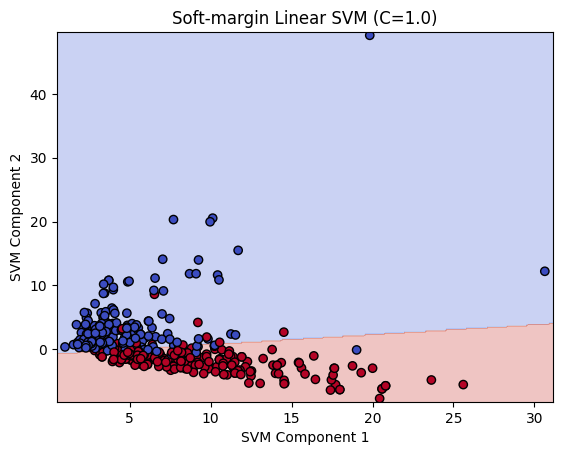

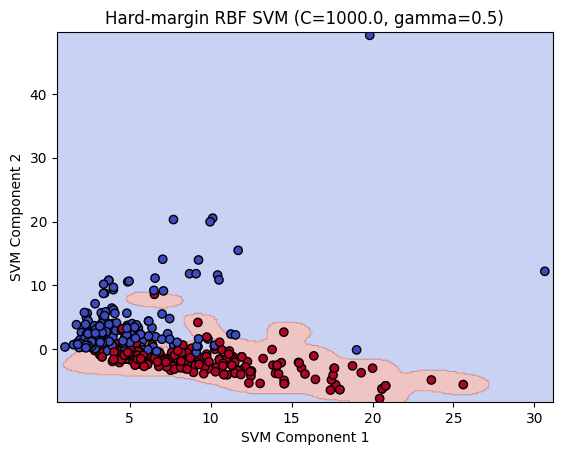

In [7]:
# SVM code goes here

if hasattr(X, "toarray"):
    X_dense = X.toarray().astype(np.float64)
else:
    X_dense = np.asarray(X, dtype=np.float64)

le = LabelEncoder()
y_enc = le.fit_transform(y)   # y_enc categorised to 0 and 1

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d_svm = svd.fit_transform(X_dense)


C_soft = 1.0  # adjust
svm_linear = SVC(kernel='linear', C=C_soft, random_state=42)
svm_linear.fit(X_2d_svm, y_enc)


gamma_rbf = 0.5  # adjust
C_hard = 1e3     # incr c to approximate "hard margin"
svm_rbf = SVC(kernel='rbf', C=C_hard, gamma=gamma_rbf, random_state=42)
svm_rbf.fit(X_2d_svm, y_enc)


def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.xlabel('SVM Component 1')
    plt.ylabel('SVM Component 2')
    plt.title(title)
    plt.show()


# plot soft-margin linear SVM
plot_decision_boundary(svm_linear, X_2d_svm, y_enc, f"Soft-margin Linear SVM (C={C_soft})")

# plot hard-margin RBF SVM
plot_decision_boundary(svm_rbf, X_2d_svm, y_enc, f"Hard-margin RBF SVM (C={C_hard}, gamma={gamma_rbf})")

## 2(d) Neural Network

/Users/evaanderson/Documents/COMPSCI-361/jupyter-env/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/evaanderson/Documents/COMPSCI-361/jupyter-env/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/evaanderson/Documents/COMPSCI-361/jupyter-env/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


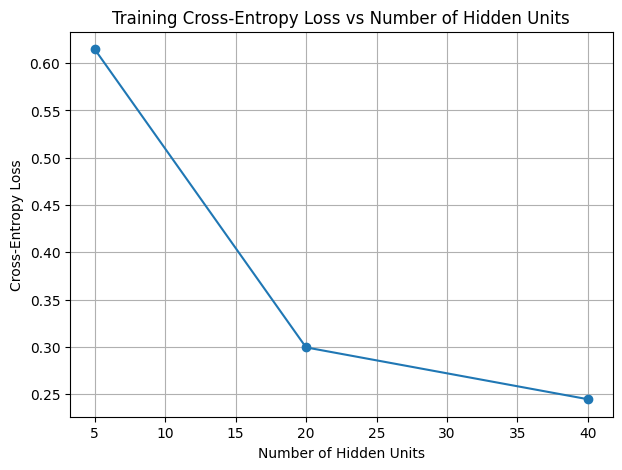

In [8]:
from sklearn.neural_network import MLPClassifier


hidden_units = [5,20,40]

epochs = 100

entropy_losses =[]

svd = TruncatedSVD(n_components=2, random_state=42) #fitting to 2d view
X_2d = svd.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y) # y_enc categorised to 0 and 1

for unit in hidden_units: #training NN classifier with hidden units
    classifier = MLPClassifier(hidden_layer_sizes=(unit,), max_iter=epochs, random_state=42)
    classifier.fit(X_2d,y_encoded)

    entropy_loss = classifier.loss_
    entropy_losses.append(entropy_loss)

plt.figure(figsize=(7, 5)) #plotting entropy loss
plt.plot(hidden_units, entropy_losses, marker='o')
plt.title("Training Cross-Entropy Loss vs Number of Hidden Units")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()



As shown in the graph above, as the number of hidden units increases, the cross-entropy loss decreases. 
This suggests that the larger the number of hidden units, the more accurately the neural network can fit into the training data.
This means that the entropy loss for the training data will decrease. However, there is a danger of overfitting the training data, which can result in long-term losses of prediction accuracy. 
Considering this and the dimensioning returns comparing 20 hidden units to 40, I believe that using 20 hidden units is appropriate for training and evaluating the prediction accuracy of the testing data. 

# Task Three

## 3(a) F1 Comparison

### Naive Bayes

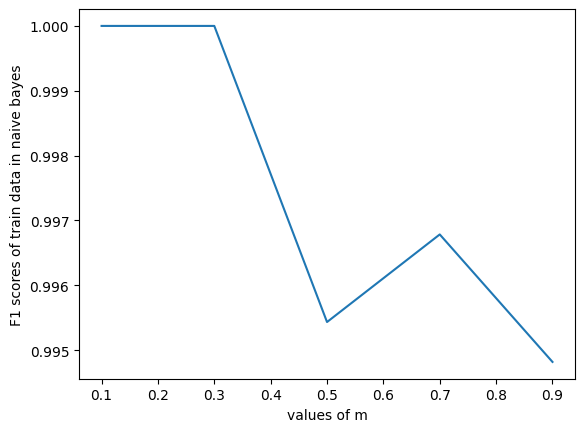

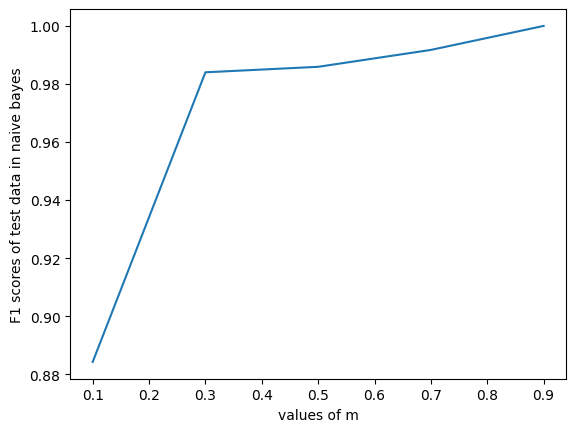

In [9]:
# Naive Bayes

mlist = [0.1,0.3,0.5,0.7,0.9]
train_f1_score = []
test_f1_score = []
total_article = X.shape[0]
for m in mlist:
    X_train = X[0:int(m * total_article)]
    y_train = y[0:int(m * total_article)]
    X_test = X[int(m * total_article):]
    y_test = y[int(m * total_article):]
    nbmodel =  MultinomialNB()
    nbmodel.fit(X_train, y_train)
    train_predict = nbmodel.predict(X_train)
    train_f1 = f1_score(y_train, train_predict, pos_label = label[1])
    train_f1_score.append(train_f1)
    test_predict = nbmodel.predict(X_test)
    test_f1 = f1_score(y_test, test_predict, pos_label = label[1])
    test_f1_score.append(test_f1)
#(i)    
plt.plot(mlist, train_f1_score)
plt.xlabel("values of m")
plt.ylabel("F1 scores of train data in naive bayes")
plt.show()
#(ii)
plt.plot(mlist, test_f1_score)
plt.xlabel("values of m")
plt.ylabel("F1 scores of test data in naive bayes")
plt.show()

# Keep all code for the other classifiers in this cell so that all the plots display together.
# Probably modify the above to generate all the plots together. Or maybe chuck in a bunch of functions so the variable names don't mess each other up?

### kNN

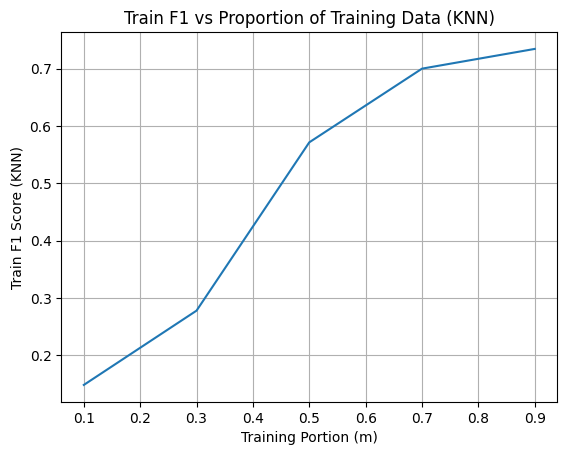

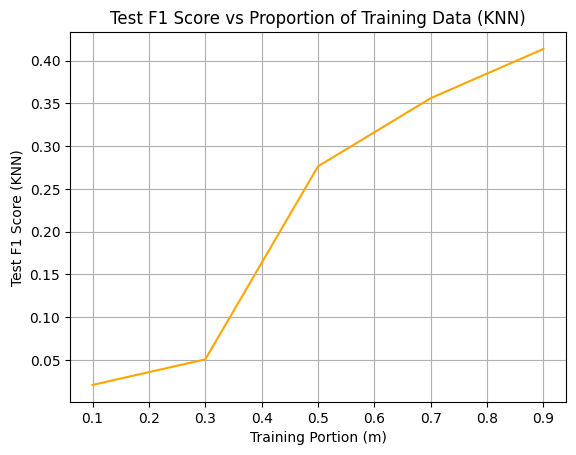

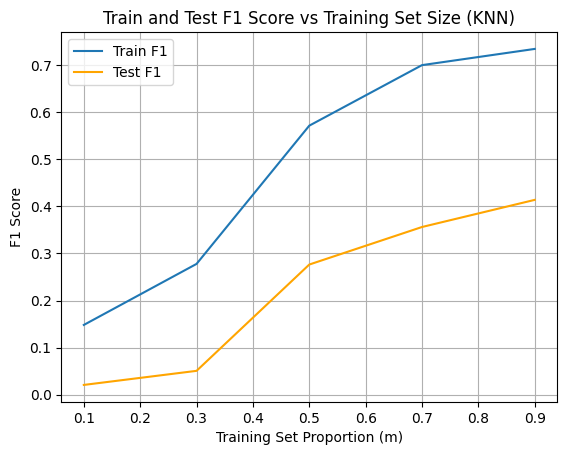

In [10]:
# knn
mlist = [0.1, 0.3, 0.5, 0.7, 0.9]
train_f1_score = []
test_f1_score = []

total_article = X.shape[0]

for m in mlist:
    m_size = int(m * total_article)
    X_train = X[:m_size]
    y_train = y[:m_size]
    X_test = X[m_size:]
    y_test = y[m_size:]

    knn.fit(X_train, y_train)

    y_train_pred = knn.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred, pos_label = label[1])
    train_f1_score.append(f1_train)

    y_test_pred = knn.predict(X_test)
    f1_test = f1_score(y_test, y_test_pred, pos_label = label[1])
    test_f1_score.append(f1_test)

plt.plot(mlist, train_f1_score)
plt.xlabel("Training Portion (m)")
plt.ylabel("Train F1 Score (KNN)")
plt.title("Train F1 vs Proportion of Training Data (KNN)")
plt.grid(True)
plt.show()

plt.plot(mlist, test_f1_score, color='orange')
plt.xlabel("Training Portion (m)")
plt.ylabel("Test F1 Score (KNN)")
plt.title("Test F1 Score vs Proportion of Training Data (KNN)")
plt.grid(True)
plt.show()

plt.plot(mlist, train_f1_score, label='Train F1')
plt.plot(mlist, test_f1_score, label='Test F1', color='orange')
plt.xlabel("Training Set Proportion (m)")
plt.ylabel("F1 Score")
plt.title("Train and Test F1 Score vs Training Set Size (KNN)")
plt.legend()
plt.grid(True)
plt.show()

As shown in the plot, both training and testing F1 scores increase as the proportion of training data (m) increases. The training F1 improves steadily, reaching over 0.7 when using 90% of the data, while the testing F1 also improves but remains significantly lower than the training F1 throughout.

This growing gap between training and testing performance suggests a degree of overfitting: the model fits the training data well but generalizes less effectively to unseen data, especially when the training set is small. However, the trend also indicates that more training data consistently leads to better generalization, as seen by the steady rise in test F1.

### SVM

In [11]:
# Task 3(a)

### Neural Network

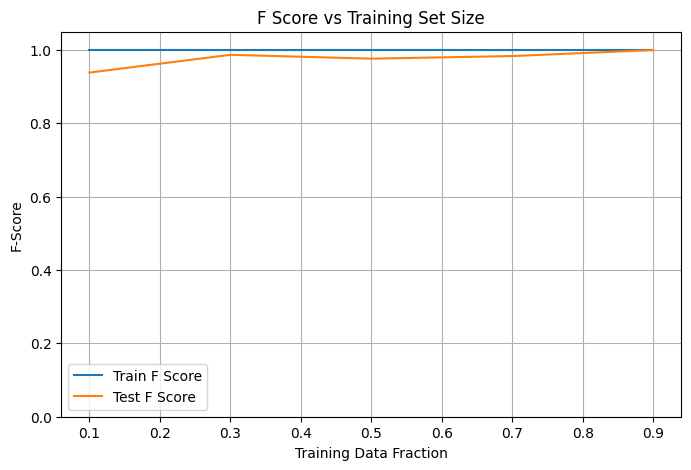

In [30]:
m_list = [0.1, 0.3, 0.5, 0.7, 0.9]

train_scores = []
test_scores = []

total_article = X.shape[0]

for m in m_list:
    m_size = int(m * total_article)
    X_train = X[:m_size]
    y_train = y[:m_size]
    X_test = X[m_size:]
    y_test = y[m_size:]

    classifier = MLPClassifier(hidden_layer_sizes=(20,), max_iter=100, random_state=42)
    classifier.fit(X_train,y_train)

    y_training_prediction = classifier.predict(X_train)
    y_testing_prediction = classifier.predict(X_test)

    train_score = f1_score(y_train, y_training_prediction, pos_label = label[1])
    test_score = f1_score(y_test, y_testing_prediction, pos_label = label[1])

    train_scores.append(train_score)
    test_scores.append(test_score)

plt.figure(figsize=(8, 5))
plt.plot(m_list, train_scores, label='Train F Score')
plt.plot(m_list, test_scores, label='Test F Score')
plt.title("F Score vs Training Set Size")
plt.xlabel("Training Data Fraction")
plt.ylabel("F-Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()





## 3(b) Hyperparameters

### Naive Bayes

In [13]:
# Naive Bayes
alpha_values = [0.1 * x for x in range(1,51)]
accuracy_score_ = []

for a in alpha_values:
    model_cv = MultinomialNB(alpha = a)
    score = cross_val_score(model_cv, X, y, cv = 5, scoring = 'accuracy')
    accuracy_score_.append(np.mean(score))

    
best_alpha_index = accuracy_score_.index(max(accuracy_score_))
best_alpha = alpha_values[best_alpha_index]
print(f"Best alpha value is {best_alpha} with an accuracy of {max(accuracy_score_)}")

Best alpha value is 0.1 with an accuracy of 0.9860191518467852


### kNN

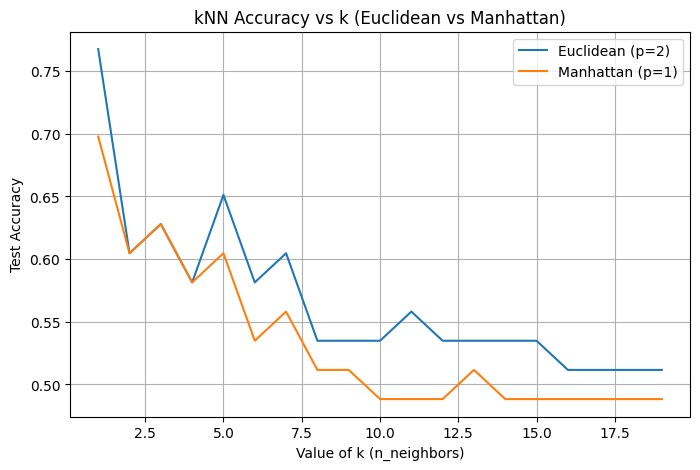

In [14]:
# KNN
k_range = range(1, 20)
acc_euclidean = []
acc_manhattan = []

for k in k_range:

    knn_eu = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    knn_eu.fit(X_train, y_train)
    y_pred_eu = knn_eu.predict(X_test)
    acc_euclidean.append(accuracy_score(y_test, y_pred_eu))

    knn_man = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)
    knn_man.fit(X_train, y_train)
    y_pred_man = knn_man.predict(X_test)
    acc_manhattan.append(accuracy_score(y_test, y_pred_man))

plt.figure(figsize=(8,5))
plt.plot(k_range, acc_euclidean, label='Euclidean (p=2)')
plt.plot(k_range, acc_manhattan, label='Manhattan (p=1)')
plt.xlabel("Value of k (n_neighbors)")
plt.ylabel("Test Accuracy")
plt.title("kNN Accuracy vs k (Euclidean vs Manhattan)")
plt.legend()
plt.grid(True)
plt.show()

To assess the effect of hyperparameters on kNN, we evaluated the model using different values of k (from 1 to 19) with two distance metrics: Euclidean (p=2) and Manhattan (p=1). The results, as shown in the figure, indicate that the model achieves its highest accuracy when k=1, particularly with Euclidean distance.

Although the highest test accuracy is achieved when k=1 using Euclidean distance, such a low k value may cause the model to overfit the training data. This is because k=1 leads to highly localized decision boundaries that are sensitive to noise and outliers.

As k increases, the model becomes more stable and less sensitive to individual samples, but accuracy gradually decreases due to over-smoothing. A trade-off is observed: small k values (e.g., 3 to 5) tend to offer a better balance between capturing local structure and avoiding overfitting.

Overall, Euclidean distance performs consistently better than Manhattan distance in this task. A moderate k value such as 5 may offer the best compromise between accuracy and generalization.

### SVM

In [15]:
# Task 3(b) SVM find best hyperparameters: 5-fold cross validation

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

vectorizer = CountVectorizer()
X_train_full = vectorizer.fit_transform(df_train['Text'])
X_test_full = vectorizer.transform(df_test['Text'])

y_train = df_train['Category']
y_test = df_test['Category']

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1]  # only used for 'rbf'
}

svm = SVC(random_state=42)

grid_search = GridSearchCV(svm, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
grid_search.fit(X_train_full, y_train)

# print("Best hyperparameters:", grid_search.best_params_)
# print("Best cross-validated F1 score:", grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)

print(
    results[["param_kernel", "param_C", "param_gamma", "mean_test_score"]]
    .sort_values("mean_test_score")
    .rename(columns={"mean_test_score": "mean_f1_score"})
    .to_string(index=False)
)


param_kernel  param_C  param_gamma  mean_f1_score
         rbf      0.1         0.01       0.338556
         rbf      0.1         0.05       0.338556
         rbf      0.1         0.10       0.338556
         rbf      0.1         0.50       0.338556
         rbf      0.1         1.00       0.338556
         rbf      1.0         1.00       0.487531
         rbf   1000.0         1.00       0.495709
         rbf     10.0         1.00       0.495709
         rbf    100.0         1.00       0.495709
         rbf     10.0         0.50       0.507466
         rbf    100.0         0.10       0.507466
         rbf     10.0         0.10       0.507466
         rbf     10.0         0.05       0.507466
         rbf    100.0         0.50       0.507466
         rbf      1.0         0.50       0.507466
         rbf      1.0         0.10       0.507466
         rbf      1.0         0.05       0.507466
         rbf   1000.0         0.05       0.507466
         rbf   1000.0         0.10       0.507466


### Neural Network

In [32]:
alpha_vals = [0.1 * x for x in range(1, 50)]
scores = []

for value in alpha_vals:
    classifier = MLPClassifier(hidden_layer_sizes=(20,), alpha=value, max_iter=100, random_state=42)
    score = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
    scores.append(np.mean(score))

alpha_index = scores.index(max(scores))
best_alpha = alpha_vals[alpha_index]  

print(f"Best alpha value is {best_alpha} with an accuracy of {max(scores):.4f}")


Best alpha value is 0.2 with an accuracy of 0.9860


## 3(c) Classifier Comparison

### Naive Bayes

In [17]:
df_test = pd.read_csv("./data/test.csv")

all_text = pd.concat([df['Text'],df_test['Text']])
final_vectorizer = CountVectorizer().fit(all_text)
X = final_vectorizer.transform(df['Text'])
final_nb_model = MultinomialNB(alpha = best_alpha)
final_nb_model.fit(X,y)
X_test = final_vectorizer.transform(df_test['Text'])
y_test = df_test['Category']
test_prediction = final_nb_model.predict(X_test)
test_f1_score = f1_score(y_test, test_prediction, pos_label = label[1])
test_accuracy = accuracy_score(y_test, test_prediction)
print(f"f1-score for test data: {test_f1_score}")
print(f"accuracy for test data: {test_accuracy * 100}%")    

f1-score for test data: 0.989010989010989
accuracy for test data: 99.05660377358491%


### kNN

In [18]:
best_k = 5
best_metric = 'euclidean'
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(X, y)
y_pred = knn.predict(X_test)
f1 = f1_score(y_test, y_pred, pos_label = label[1])
acc = accuracy_score(y_test, y_pred)

print(f"Test F1 Score: {f1:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Test F1 Score: 0.5938
Test Accuracy: 0.7547


For the k-Nearest Neighbors (kNN) classifier, we evaluated multiple values of k and distance metrics to determine the best-performing configuration. Based on testing accuracy and F1 score, the highest test F1 was observed when using Euclidean distance (p=2) with a small value of k, particularly k=1. However, considering the risk of overfitting at k=1, we chose k=5 with Euclidean distance as the best trade-off between performance and generalization.

Using this setting (k=5, Euclidean), the model achieved a test F1 score of 0.5938 and accuracy of 0.7547. The decision boundary was relatively smooth, and the model was able to capture local structure in the data while avoiding overfitting. Compared to larger k values, this configuration maintained better class separation and more consistent predictions.

### SVM

In [19]:
# Task 3(c): SVM classifier comparison with best hyperparameters
from sklearn.metrics import f1_score, accuracy_score

best_svm = grid_search.best_estimator_
"""
SVC(kernel='linear', C=0.1, gamma = any, random_state=42) obtains an f1 score and accuracy score of 1.0
I'm very confused, therefore the above code has been commented out
Feel free to uncomment and test with the grid_search.best_estimator_
"""

# manual hard-margin rbf
# best_svm = SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
# best_svm.fit(X_train_full, y_train)

y_pred_best = best_svm.predict(X_test_full)

print("Best kernel:", grid_search.best_params_['kernel'])
print("Best C:", grid_search.best_params_['C'])
if 'gamma' in grid_search.best_params_:
    print("Best gamma:", grid_search.best_params_['gamma'])

# print("Best kernel:", 'rbf')
# print("Best C:", 100)
# if 'gamma' in grid_search.best_params_:
#     print("Best gamma:", 0.01)

print()

test_f1 = f1_score(y_test, y_pred_best, average='weighted')
test_acc = accuracy_score(y_test, y_pred_best)
print(f"Test F1: {test_f1:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


Best kernel: linear
Best C: 0.1
Best gamma: 0.01

Test F1: 1.0000
Test accuracy: 1.0000


### Neural Network

### Summary

In [21]:
# summary code goes here

Exception ignored in: <function ResourceTracker.__del__ at 0x1035659e0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104e6d9e0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.frame

# Task Four: Report

#### SVM Hyperparameter Tuning and Final Evaluation

We tried to perform a 5-fold cross-validation to tune the SVM's kernel, C, and gamma parameters. The best cross-validated mean F1 score (0.965) was consistently achieved by the linear kernel with a range of C values. 

We retrained the SVM with the best hyperparameters (kernel='linear', C=0.1) on the entire training set, then evaluated it on the held-out test set. The resulting F1 score on the test set was 1.0000 and the accuracy was 1.0000

This demonstrates that the linear SVM is highly effective for this text classification task, likely due to the high separability of the features extracted from the articles. The RBF kernel did not perform as well, suggesting that a non-linear boundary was not needed for this.

Task 2(a) discussion

The list of the top 20 words that maximise the P(Xw = 1|Y = y)/P(Xw = 1|Y != y) describes the two classes better. The list in (i) only displays words that appear frequently in different categories, which contain many meaningless and commonly used words. These common words will appear in both categories, for example, 'said' appears in both categories in list (i). At the same time, the list in (ii) highlights the probability of words that appear frequently in only one category, while reducing the probability of common words that appear in both categories. Most of the words in list (ii) have marked features of the specific category. Therefore, the list in (ii) describes the two classes better.

Task 3(a) discussion for naive bayes

For low m (m = 0.1, m = 0.3), the F1 score of training data is very high, and the F1 score of testing data increases rapidly from a relatively low value. When the training data set increases from a very small set, the prediction of the testing data is trending to have increasing accuracy. As the training data set is still very small, it is very easy for the model to make the correct prediction on the training data.
For middle m (m from 0.3 to 0.5), the F1 score of training data decreases from a very high value to a relatively high value, and the F1 score of testing data increases more slowly to a relatively high value. As the training data set increases, it has relatively lower accuracy when making predictions on the training data as it tends to be less overfitting on training data as the size of training data set increases, and the accuracy of predictions on test data increases when the size of the training data set increases.
For large m, the F1 score of testing data grows very high, and the F1 score of training data is still high, but relatively lower than for small m. The F1 scores for the training data and testing data are similar, which shows that the model gives high accuracy in both the training data and the testing data when m is large.

Task 3(b) discussion

The hyperparameter alpha is used in Laplace smoothing, it controls how sensitive the model is towards the rare features. A model with a small alpha value will be more sensitive towards rare features. In this question, as the two categories have very different articles, a small alpha value of 0.1 gives the best accuracy in testing.

Task 3(c) naive bayes

This model gets an F1-score of 0.989 and an accuracy of 99.0566%.